In [1]:
# Install Packages
import sys
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install seaborn
!{sys.executable} -m pip install sklearn

from sklearn import preprocessing
import os, requests
from matplotlib import rcParams 
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

# Data Retrieval

fname = 'joystick_track.npz'
url = "https://osf.io/6jncm/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)
# Import matplotlib and set styling
import seaborn as sns
rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

colourmap_diverge = sns.diverging_palette(321, 172, s=100, n=100, center = "light", as_cmap=True)
colourmap = sns.color_palette("deep", as_cmap=True)
#colourmap = sns.light_palette("#30887c", as_cmap=True)
colourmap_diverge.set_bad("black", alpha=0)
sns.set_palette("deep")
sns.set_style('darkgrid')


# Data Loading
alldat = np.load(fname, allow_pickle=True)['dat']

# Select just one of the recordings here. This is subject 1, block 1.
dat = alldat[0, 3]

In [2]:
# Helper functions

def normalise(x):
    return (x-min(x))/(max(x)-min(x))

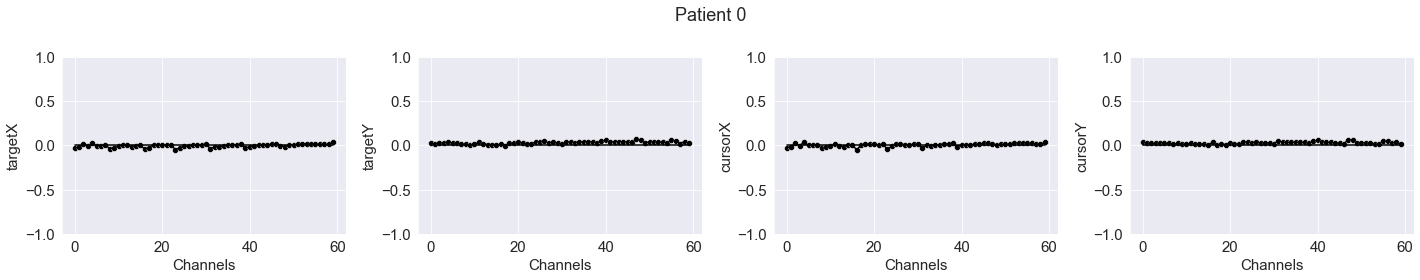

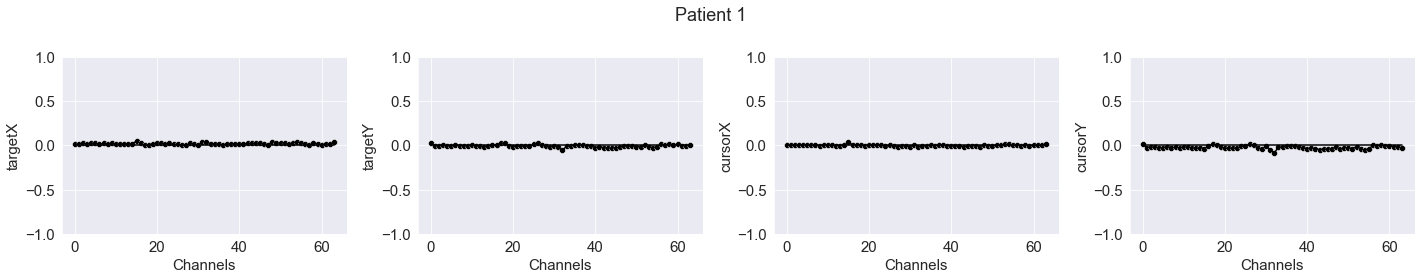

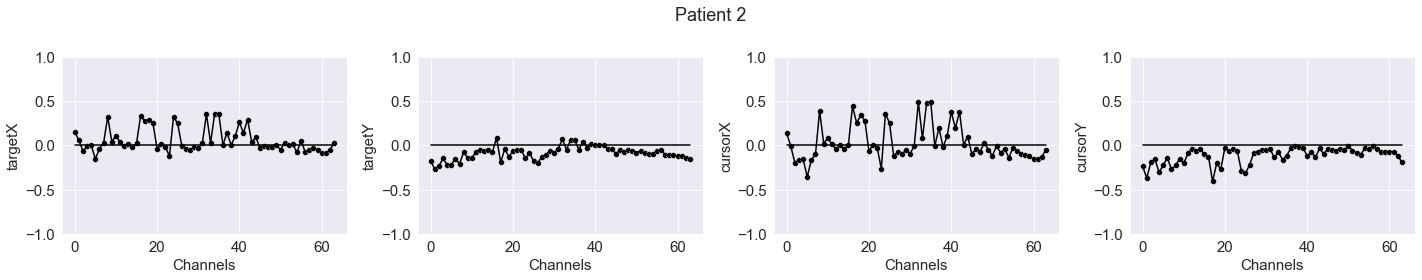

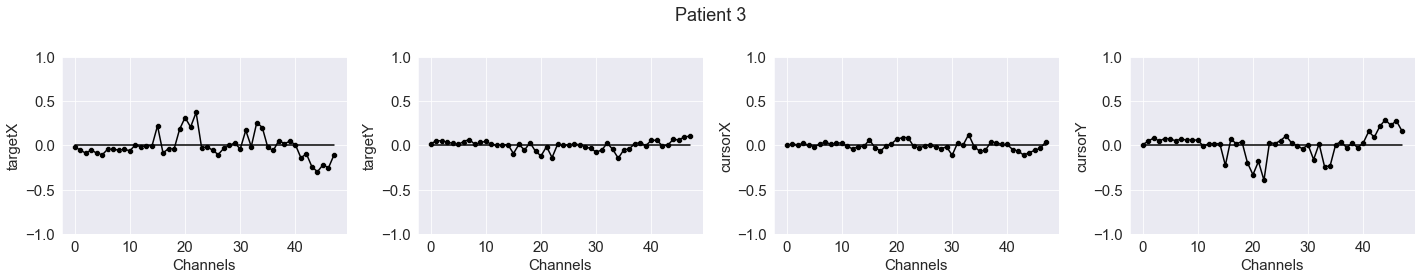

In [3]:
# Pearson Correlation between Voltage channel and Cursor
allcors = dict()
for p in range(4):
    data = alldat[0, p]

    V = data['V'].astype('float32')
    nt, nchan = V.shape

    cors = dict()
    cors['Channels'] = range(nchan)
    for key in ['targetX', 'targetY', 'cursorX', 'cursorY']:
        correlations = []
        for i in range(nchan):
            correlations.append(np.corrcoef(normalise(V[:, i]), normalise(data[key].flatten()))[0, 1])
        cors[key] = correlations

    plt.figure()
    plt.suptitle('Patient ' + str(p))
    for i, (key, value) in enumerate(cors.items()):
        if key != 'Channels':
            plt.subplot(1,4,i)
            sns.scatterplot(data=cors, x='Channels', y=key, color='k')
            sns.lineplot(data=cors, x='Channels', y=key, color='k')
            plt.plot(np.zeros([1, nchan])[0], color='k')
            plt.ylim(-1, 1)
            
    allcors['P'+str(p)] = cors

In [4]:
for patient in ['P3', 'P2']:
    print(patient)
    cors = allcors[patient]
    
    for key in ['targetX', 'targetY', 'cursorX', 'cursorY']:
        cor_sort = sorted(cors[key])
        max_cors = cor_sort[:3]
        max_cors_indices = []
        for c in max_cors:
            if c > 0.25 or c < -0.25:
                max_cors_index = cors[key].index(c)
                max_cors_indices.append(cors['Channels'][max_cors_index])
                print(cors['Channels'][max_cors_index], c, key)
    print(" ")

P3
44 -0.29852001066310774 targetX
46 -0.2542084002822932 targetX
22 -0.39388477984122283 cursorY
20 -0.3322406671730013 cursorY
 
P2
1 -0.2724806799995443 targetY
5 -0.3566817375300507 cursorX
23 -0.26472687800410377 cursorX
17 -0.4079684047526614 cursorY
1 -0.3717842963787577 cursorY
25 -0.3163399915770976 cursorY
 


<Figure size 1440x288 with 0 Axes>

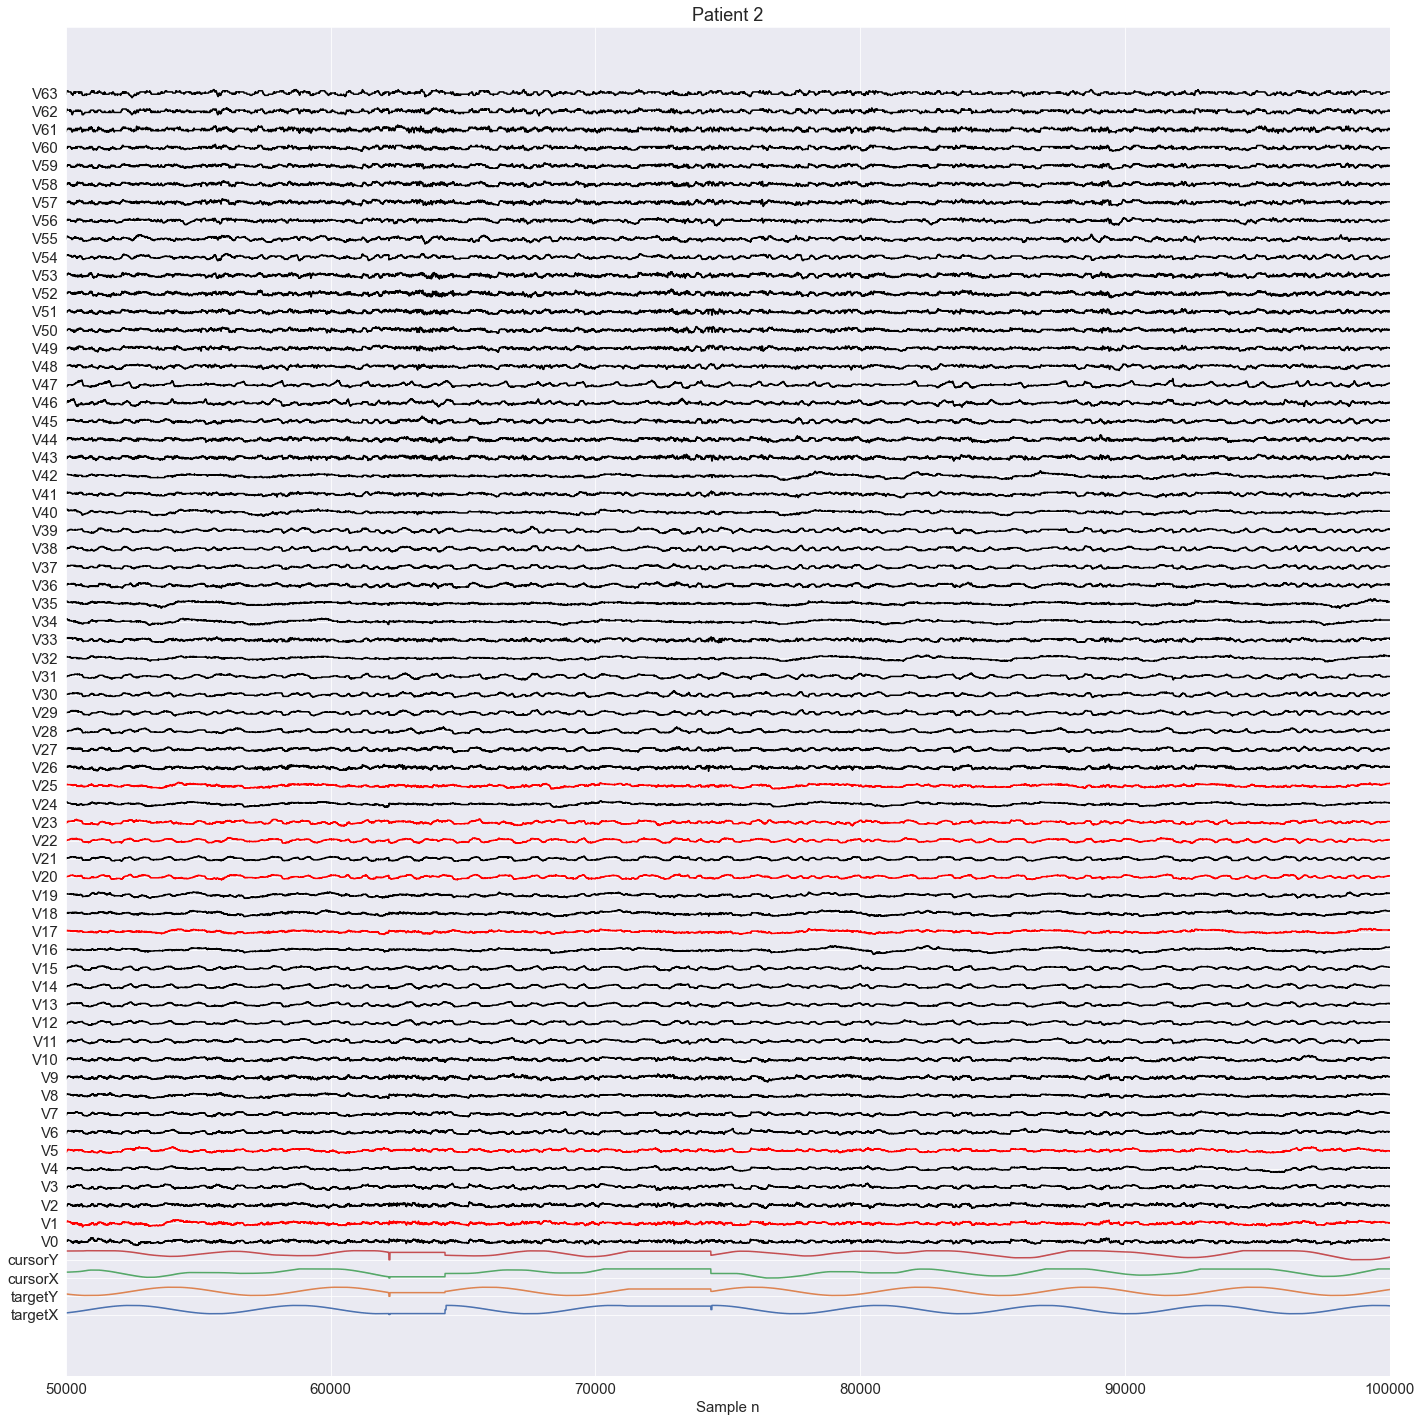

<Figure size 1440x288 with 0 Axes>

In [5]:
# Values set as above, focusing on Patient 2 correlations with cursor values
corr_chan = sorted([5, 23, 22, 20, 17, 1, 25])

p = 2
dat = alldat[0, p]

V = dat['V']
V_norm = preprocessing.normalize(V)

targetX = dat['targetX'].flatten()
targetY = dat['targetY'].flatten()
targetX_norm = preprocessing.normalize([targetX])[0]
targetY_norm = preprocessing.normalize([targetY])[0]

cursorX = dat['cursorX'].flatten()
cursorY = dat['cursorY'].flatten()
cursorX_norm = preprocessing.normalize([cursorX])[0]
cursorY_norm = preprocessing.normalize([cursorY])[0]

nchan = V.shape[1] #Number of channels
nt = V.shape[0]    #Number of data points

#number of signals to plot (nchan + target X,Y + cursor X,Y)
signals = dict()
labels = ['targetX', 'targetY', 'cursorX', 'cursorY']
ticklabels = []
ticks = [0, 2, 4, 6]
signals['targetX'] = targetX_norm / max(targetX_norm)
signals['targetY'] = targetY_norm / max(targetY_norm)
signals['cursorX'] = cursorX_norm  / max(cursorX_norm)
signals['cursorY'] = cursorY_norm / max(cursorY_norm)
ticklabels.append('targetX')
ticklabels.append('targetY')
ticklabels.append('cursorX')
ticklabels.append('cursorY')
for c in range(nchan):
    signals['V' + str(c)] = V_norm[:,c].flatten()
    ticklabels.append('V' + str(c))
    ticks.append(ticks[-1] + 2)



plt.figure(figsize=(20, 20))
for i, (label, signal) in enumerate(signals.items()):
    #print(min(signal), max(signal))
    if label[0] == 'V':
        if i-4 not in corr_chan:
            plt.plot(signal + i*2, color='k')
        else:
            plt.plot(signal + i*2, color='r')
    else:
        plt.plot(signal + i*2)


plt.xlim(50000, 100000)
plt.title('Patient ' + str(p))
ax = plt.gca()
ax.set_yticks(ticks)
ax.set_yticklabels(ticklabels)
plt.xlabel('Sample n')
plt.figure()




channels visualised: [1, 17, 25]
(134360, 3)
1
17
25


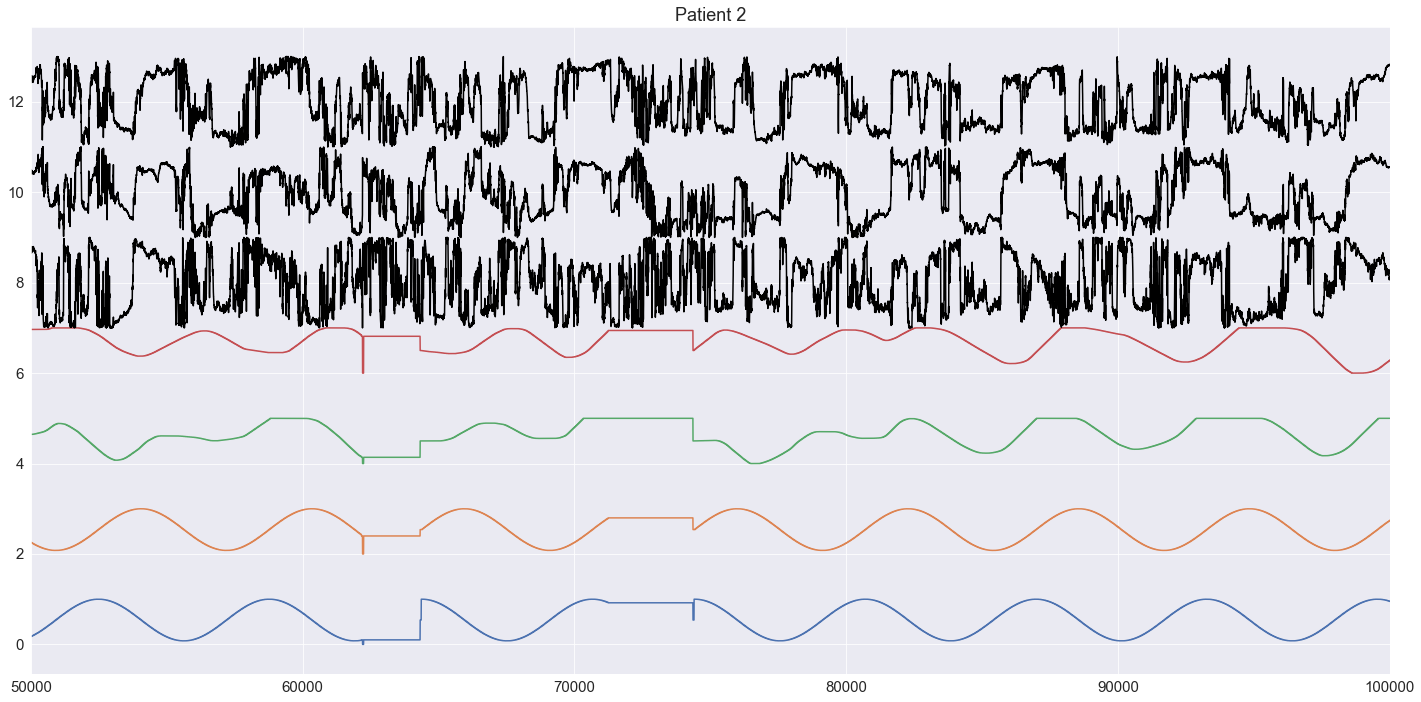

In [14]:
# Values set as above, focusing on Patient 2 correlations with cursor values
corr_chan = sorted([5, 23, 17, 1, 25])

p = 2
dat = alldat[0, p]

print("channels visualised:", sorted(max_cors_indices))

V_correlated = dat['V'][:, sorted(max_cors_indices)]
print(V_correlated.shape)
V_norm = preprocessing.normalize(V_correlated)

targetX = dat['targetX'].flatten()
targetY = dat['targetY'].flatten()
targetX_norm = preprocessing.normalize([targetX])[0]
targetY_norm = preprocessing.normalize([targetY])[0]

cursorX = dat['cursorX'].flatten()
cursorY = dat['cursorY'].flatten()
cursorX_norm = preprocessing.normalize([cursorX])[0]
cursorY_norm = preprocessing.normalize([cursorY])[0]

nchan = V_correlated.shape[1] #Number of channels
nt = V_correlated.shape[0]    #Number of data points

#number of signals to plot (nchan + target X,Y + cursor X,Y)
signals = dict()
labels = ['targetX', 'targetY', 'cursorX', 'cursorY']
signals['targetX'] = targetX_norm / max(targetX_norm)
signals['targetY'] = targetY_norm / max(targetY_norm)
signals['cursorX'] = cursorX_norm  / max(cursorX_norm)
signals['cursorY'] = cursorY_norm / max(cursorY_norm)
for c in range(nchan):
    signals['V' + str(c)] = V_norm[:,c].flatten()



plt.figure(figsize=(20, 10))
for i, (label, signal) in enumerate(signals.items()):
    #print(min(signal), max(signal))
    if label[0] == 'V':
        plt.plot(signal + i*2, color='k')
    else:
        plt.plot(signal + i*2)

plt.xlim(50000, 100000)
plt.title('Patient ' + str(p))

plt.figure(figsize=(14, 7), dpi=1000)
for i, c in enumerate(sorted(max_cors_indices)):
    plt.subplot(3, 1, i+1)
    print(c)
    plt.plot(signals['cursorX'][10000:60000], label='cursorX', color='#C44E52')
    plt.plot(signals['cursorY'][10000:60000], label='cursorY', color='#4C72B0')
    Voltage_channel = dat['V'][10000:60000, c]
    Voltage_channel_norm = normalise(Voltage_channel)
    plt.plot(Voltage_channel_norm, label="Voltage Channel " + str(c), color='k')
    plt.xlim(00000, 50000)
    plt.ylabel('Normalised Value')
    
    plt.title('Channel ' + str(c))
plt.xlabel('Sample n')
plt.tight_layout()
plt.ylim((0, 1000))
plt.legend()

